#### includes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import mlflow
import pytorch_lightning as pl
from pytorch_lightning.utilities.cloud_io import load as pl_load
import torch
import sys

plt.rcParams["figure.figsize"] = (18, 6)

In [3]:
import sources
from steered_cnn.utils.rotequivariance_toolbox import *
from steered_cnn.steered_conv.steerable_filters import radial_steerable_filter, plot_filter
from steered_cnn.utils.clip_pad import clip_pad_center
from steered_cnn.steered_conv import SteerableKernelBase
from src.trainer import Binary2DSegmentation
from sources import load_dataset, parse_config, setup_model, default_config

## Constantes

In [81]:
EXPERIMENT_ID = 12
RUN_ID = '28df704f9c2245e4b1937e5e3a72bfac'

EXP = f'/home/gaby/mlflow/mlruns/{EXPERIMENT_ID}/{RUN_ID}/artifacts/'
cfg = parse_config(EXP+'cfg_extended.yaml')
#cfg.training['dataset-file'] = '/home/gaby/These/src/Fundus/RotInvariance/3-Git/vessels.h5'
trainD, validD, testD = load_dataset(cfg)
cfg['script-arguments']['gpus']='0'
model = setup_model(cfg.model, 6, 1)

## Initialisation

In [82]:
net = Binary2DSegmentation(model=model)
state_dict = pl_load(EXP+'best-val-roc.ckpt'.format(25), map_location='cuda:0')['state_dict']
net.load_state_dict(state_dict)
net.eval().cuda()
None

In [83]:
for d in testD['MESSIDOR']:
    break

In [84]:
THETA = 24
x = torch.from_numpy(rotate(d['x'][0].numpy(), THETA)).cuda()
mask = d['y'][0].cpu().numpy()>0

In [85]:
hooks = []

In [86]:
features = {}
def log_f(name):
    def hook(self, inputs, outputs):
        f = features.get(name, [])
        if not f:
            features[name] = f
        f += [outputs.detach().cpu().numpy()]
    return getattr(net.model, name).relu.register_forward_hook(hook)

if not hooks:
    hooks = [log_f('downconv0-1'),
             log_f('downconv1-1'),
             log_f('downconv2-1'),
             log_f('downconv3-1'),
             log_f('downconv4-1')]

with torch.no_grad():
    yhat = [net(_[None]).cpu().numpy() for _ in x]
yhat = np.stack(yhat)
yhat = unrotate(yhat, THETA)

## Polar Spectral Power Density

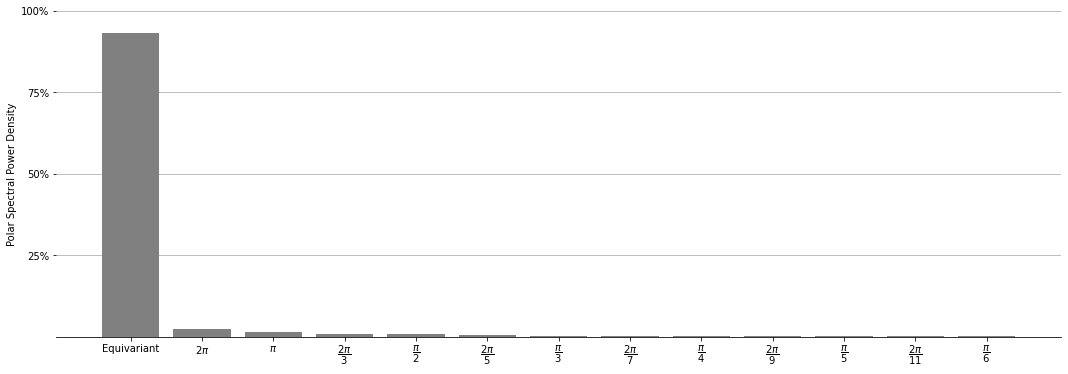

In [87]:
_ = spectral_power(yhat[..., mask], plot=True)

In [88]:
f = {k: unrotate(np.stack(v)[:,0], THETA) for k,v in features.items()}
f['downconv0-1'].shape

(24, 12, 565, 565)

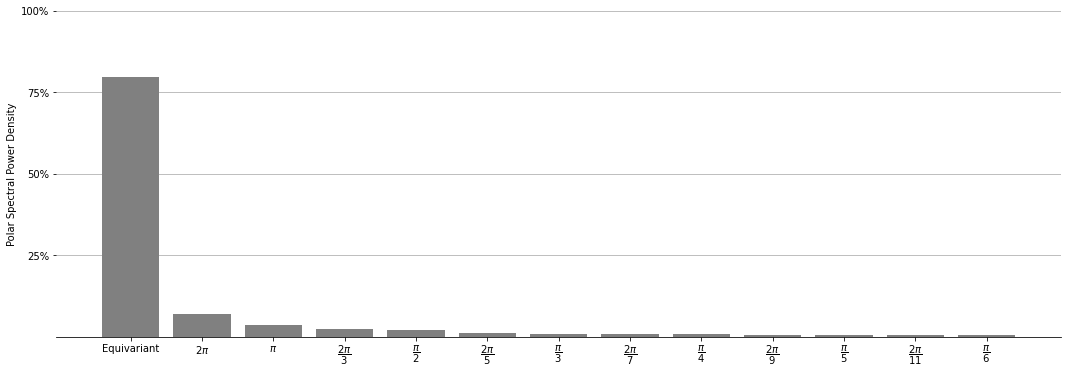

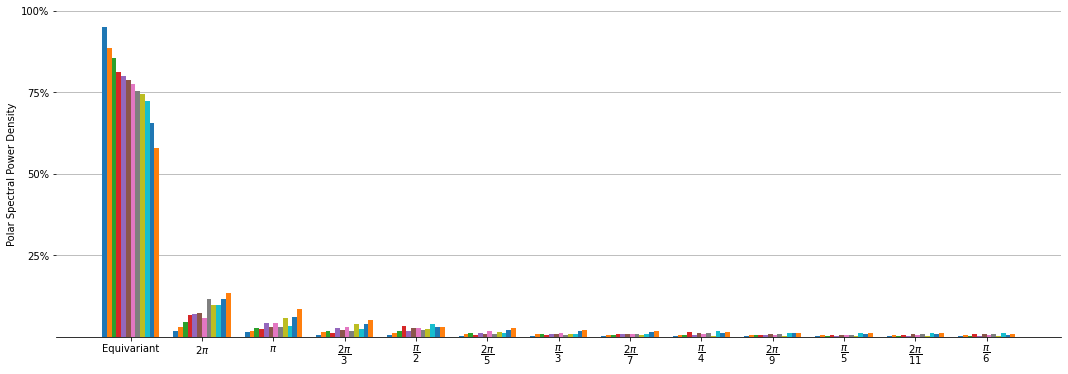

In [90]:
spe = spectral_power(f['downconv0-1'][..., mask], plot=True)
spe = spectral_power(f['downconv0-1'][..., mask], plot=True, split='normed')

#fig, axs = plt.subplots(2,4)
#for i in range(8):
#    y = spe[:, i]
#    y = y/y.sum()
#    x = np.arange(len(spe))
#    ax = axs[i//4,i%4]
#    ax.bar(x,y)

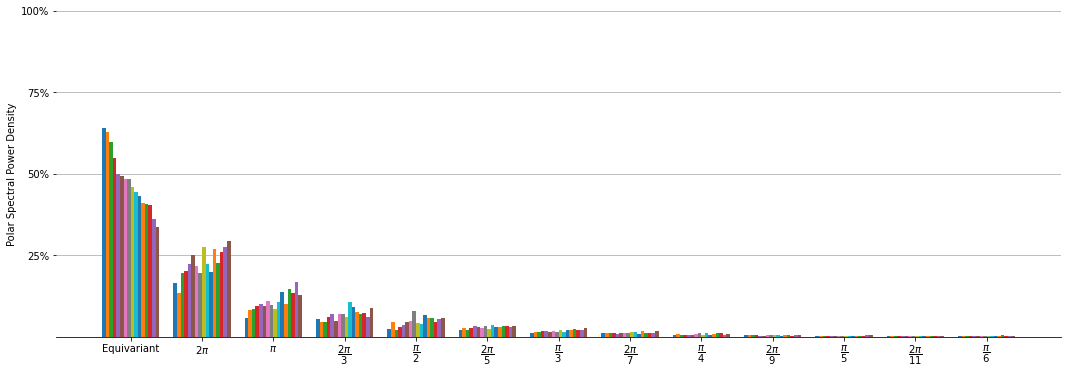

In [31]:
W = getattr(net.model, 'downconv0-1').conv.weight.detach().cpu().numpy()
spe = polar_spectral_power(W, theta=24, plot=True, split='normed')

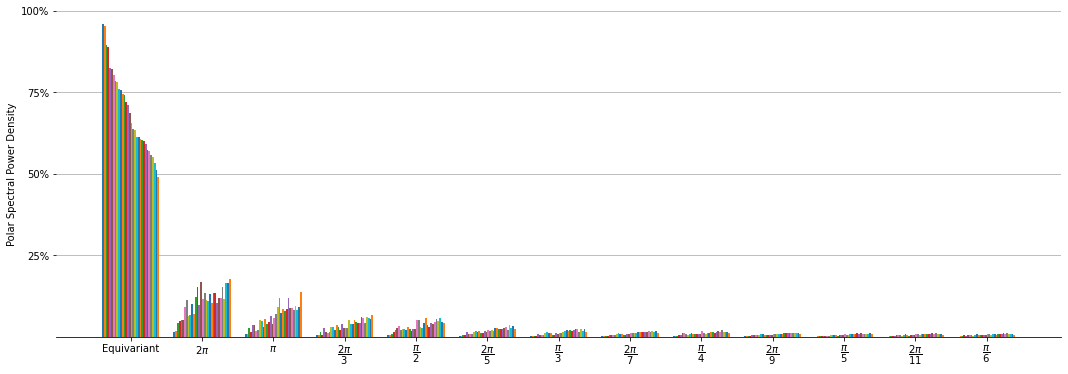

In [32]:
spe = spectral_power(f['downconv1-1'], plot=True, split='normed')

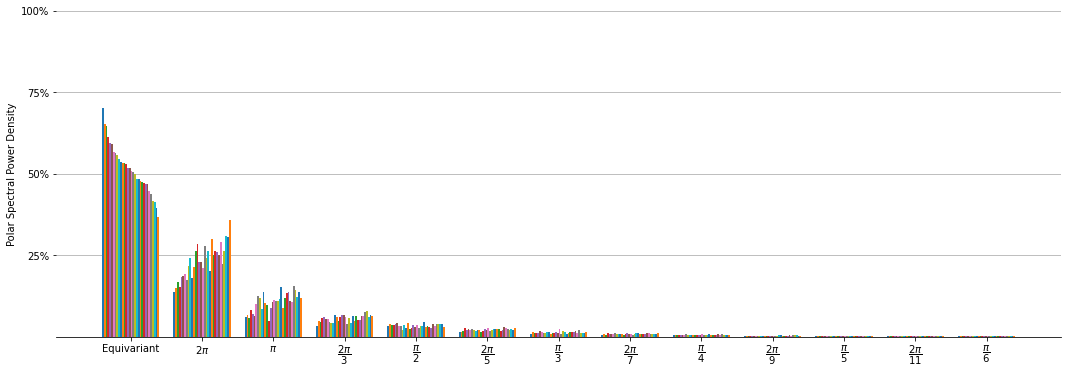

In [33]:
W = getattr(net.model, 'downconv1-1').conv.weight.detach().cpu().numpy()
spe = polar_spectral_power(W, theta=24, plot=True, split='normed')

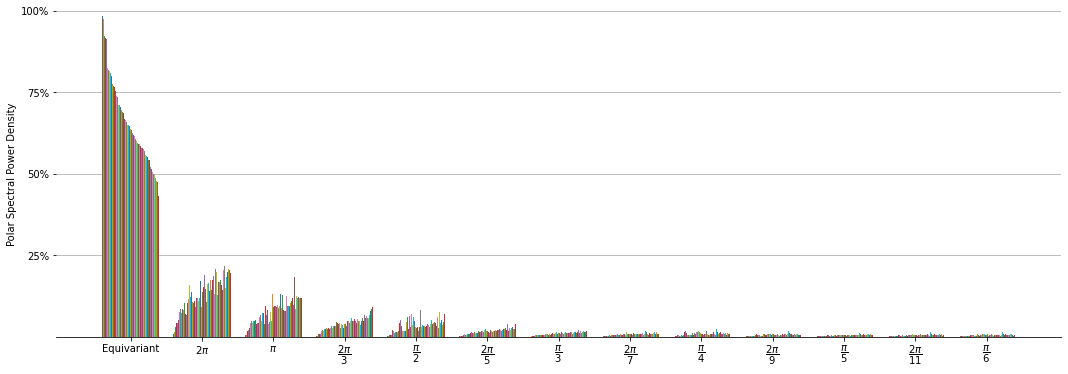

In [34]:
spe = spectral_power(f['downconv2-1'], plot=True, split='normed')

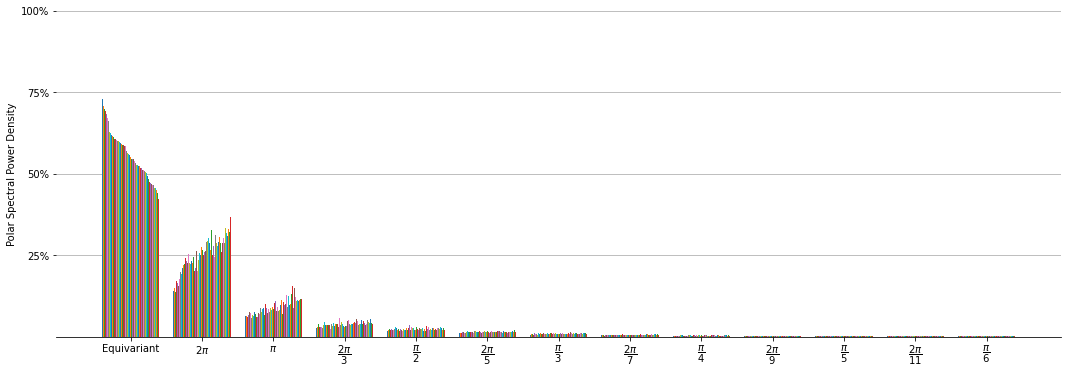

In [36]:
W = getattr(net.model, 'downconv2-1').conv.weight.detach().cpu().numpy()
spe = polar_spectral_power(W, theta=24, plot=True, split='normed')

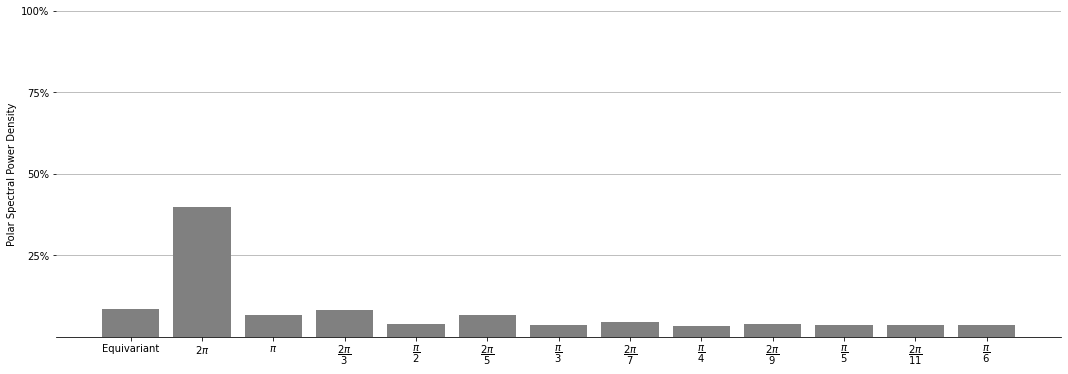

In [38]:
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

grad = np.matmul(np.linspace(-1,1,3)[:,None],np.ones((1,3)))
noise = np.random.uniform(0,1,size=(100,100))
noise = gaussian_filter(noise, 3)
noise = rotate(noise, 24)
r = np.stack([convolve2d(_, grad) for _ in noise])
r = unrotate(r, 24)
spe = spectral_power(r, plot=True)

## Steerable Check

In [50]:
cfg = default_config()
cfg.model['steered'] = 'all'
cfg.model['padding'] = 'same'
cfg.model['upsample'] = 'nearest'
cfg.training['dataset-file'] = 'av.h5'

EXPERIMENT_ID = 12
RUN_ID = 'e6a564d1c6a44f40a75d2033042e1b6e'
EXP = f'/home/gaby/mlflow/mlruns/{EXPERIMENT_ID}/{RUN_ID}/artifacts/'
cfg = parse_config(EXP+'cfg_extended.yaml')

trainD, validD, testD = load_dataset(cfg)
cfg['script-arguments']['gpus']='0'

In [76]:
THETA = 12
np_thetas = np.linspace(0, 360, THETA, endpoint=False)
thetas = -torch.from_numpy(np_thetas)[:,None,None].cuda().float()*np.pi/180
cos_sin_thetas = torch.stack((torch.cos(thetas), torch.sin(thetas)), dim=1)
np_thetas = np_thetas[1:]

for d in trainD:
    break
x = torch.from_numpy(rotate(d['x'][0].numpy(), np_thetas)).cuda()
mask = d['y'][0].numpy()>0

In [77]:
net = setup_model(cfg.model, 6, 1).cuda().eval()

**Absolute Alpha**

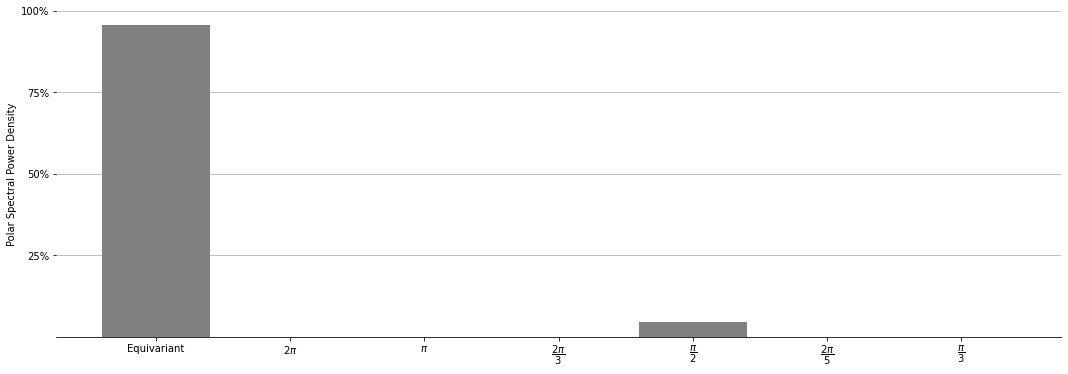

In [80]:
with torch.no_grad():
    yhat = net(x, thetas)
    yhat = clip_pad_center(yhat.detach().cpu(), mask.shape).numpy()
    yhat_unrotated = unrotate(yhat, np_thetas)
_ = spectral_power(yhat_unrotated[..., mask], plot=True)